In [30]:
%pip install transformers
%pip install torch
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
%pip install ipywidgets
%pip install jupyterlab_widgets
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
df_train = pd.read_csv("dataset/olid-training-v1.0.tsv", sep="\t")
print(df_train.head())
print(df_train['subtask_a'].value_counts())

      id                                              tweet subtask_a  \
0  86426  @USER She should ask a few native Americans wh...       OFF   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2  16820  Amazon is investigating Chinese employees who ...       NOT   
3  62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   

  subtask_b subtask_c  
0       UNT       NaN  
1       TIN       IND  
2       NaN       NaN  
3       UNT       NaN  
4       NaN       NaN  
subtask_a
NOT    8840
OFF    4400
Name: count, dtype: int64


#Step 1: Preprocess Tweets

In [33]:
import re

def clean_tweet(text):
    text = text.lower()  # lowercase
    text = re.sub(r'@user', '', text)  # remove @USER mentions
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'#\S+', '', text)  # remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df_train['clean_tweet'] = df_train['tweet'].apply(clean_tweet)
print(df_train[['tweet', 'clean_tweet']].head())


                                               tweet  \
0  @USER She should ask a few native Americans wh...   
1  @USER @USER Go home you’re drunk!!! @USER #MAG...   
2  Amazon is investigating Chinese employees who ...   
3  @USER Someone should'veTaken" this piece of sh...   
4  @USER @USER Obama wanted liberals &amp; illega...   

                                         clean_tweet  
0  she should ask a few native americans what the...  
1                            go home youre drunk url  
2  amazon is investigating chinese employees who ...  
3  someone shouldvetaken this piece of shit to a ...  
4  obama wanted liberals amp illegals to move int...  


In [ ]:
#Encode Labels
label_map = {'NOT': 0, 'OFF': 1}
df_train['label'] = df_train['subtask_a'].map(label_map)
print(df_train[['subtask_a', 'label']].value_counts())

subtask_a  label
NOT        0        8840
OFF        1        4400
Name: count, dtype: int64


In [ ]:
#Tokenize Tweets with BERT
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encodings = tokenizer(
    df_train['clean_tweet'].tolist(),
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors='pt'
)

In [ ]:
#Prepare Dataset for Training

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
labels = torch.tensor(df_train['label'].tolist())
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks = train_test_split(attention_mask, test_size=0.2, random_state=42)
batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

In [ ]:
#Define and Train BERT Model

from torch.optim import AdamW
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

epochs = 3
loss_fn = CrossEntropyLoss()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader):
        b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]

        model.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Average training loss: {total_loss / len(train_dataloader)}")


Epoch 1


100%|██████████| 662/662 [19:21<00:00,  1.75s/it]


Average training loss: 0.4660365681228681
Epoch 2


100%|██████████| 662/662 [18:39<00:00,  1.69s/it]


Average training loss: 0.35627367473530985
Epoch 3


100%|██████████| 662/662 [18:00<00:00,  1.63s/it]

Average training loss: 0.23648894425999273


In [39]:
#Evaluation of model

from sklearn.metrics import classification_report, confusion_matrix, f1_score

model.eval()
predictions, true_labels = [], []

for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(preds)
    true_labels.extend(label_ids)

# 🧾 Print Metrics
print("Classification Report:\n")
print(classification_report(true_labels, predictions, target_names=["NOT", "OFF"]))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))

print("\nMacro F1 Score:", f1_score(true_labels, predictions, average='macro'))


Classification Report:

              precision    recall  f1-score   support

         NOT       0.82      0.89      0.85      1733
         OFF       0.74      0.62      0.68       915

    accuracy                           0.79      2648
   macro avg       0.78      0.75      0.76      2648
weighted avg       0.79      0.79      0.79      2648


Confusion Matrix:
[[1538  195]
 [ 348  567]]

Macro F1 Score: 0.7630830327515137


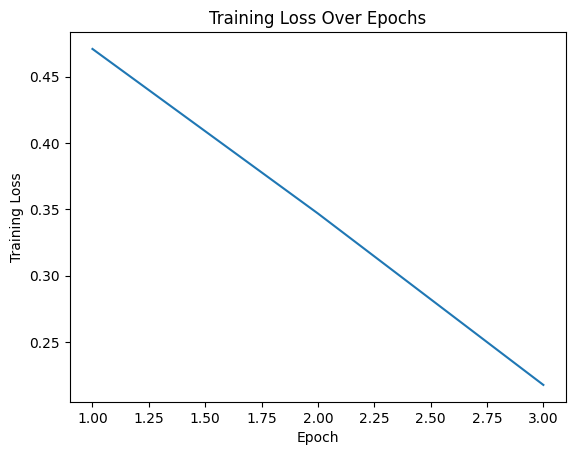

In [40]:
#Plot Training Curves
# # If you tracked `loss_values` per epoch, you could plot:
import matplotlib.pyplot as plt

loss_values = [0.4708, 0.3468, 0.2176]
plt.plot(range(1, len(loss_values)+1), loss_values)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.show()


In [ ]:
#Test on New Tweets
def predict_tweet(tweet):
    model.eval()
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return "NOT" if prediction == 0 else "OFF"
print(predict_tweet("You're such a terrible person!"))  # Should predict OFF
print(predict_tweet("Hope you're having a great day!"))  # Should predict NOT


OFF
NOT


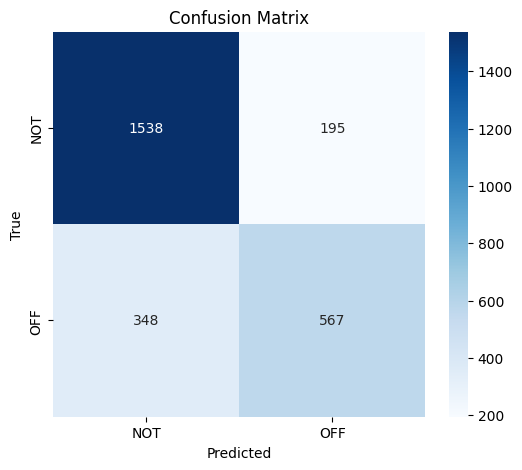

In [42]:
#Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ['NOT', 'OFF']
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


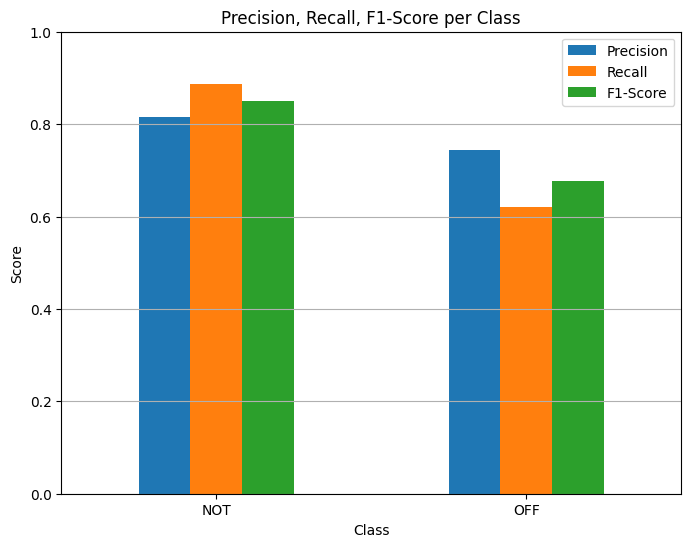

In [43]:
#F1, Precision, Recall per Class (Bar Chart)
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None, labels=[0, 1])
metrics_df = pd.DataFrame({
    'Class': ['NOT', 'OFF'],
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1
})

metrics_df.plot(x='Class', kind='bar', figsize=(8, 6), legend=True)
plt.title('Precision, Recall, F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()


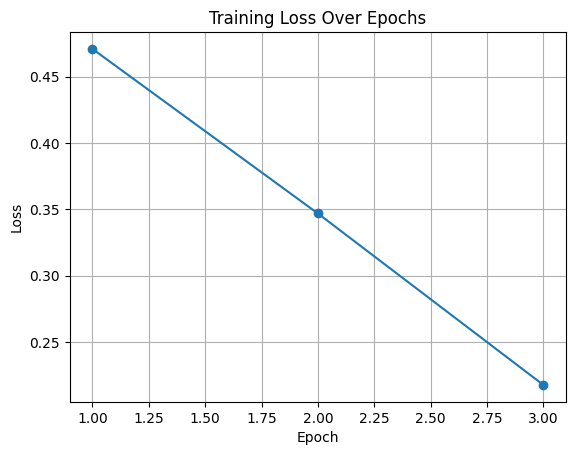

In [44]:
#Training Loss Curve (If Tracked)
loss_values = [0.4708, 0.3468, 0.2176]  # Replace with your tracked values
plt.plot(range(1, len(loss_values)+1), loss_values, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
#Most Confused Tweets
val_texts = tokenizer.batch_decode(val_inputs, skip_special_tokens=True)
df_val = pd.DataFrame({
    'text': val_texts,
    'true': true_labels,
    'pred': predictions
})
df_val['misclassified'] = df_val['true'] != df_val['pred']
misclassified_samples = df_val[df_val['misclassified']].head(10)
misclassified_samples

,text,true,pred,misclassified
12,you are lying stick with the facts we pay more...,0,1,True
16,im astounded that conservatives hold her up as...,0,1,True
18,another turd gone from espn maybe one day we c...,0,1,True
23,oh dear conservatives will implode over this,0,1,True
27,he is also said we would have the cleaner air ...,0,1,True
30,you are becoming unhinged with this game,0,1,True
36,i dont understand how its racist tho,0,1,True
37,yea jeff should go antifa is a terrorist organ...,1,0,True
39,930 pm 3rd round gun control whining and sen b...,1,0,True
40,what all 12 of them what about the terrorists ...,1,0,True


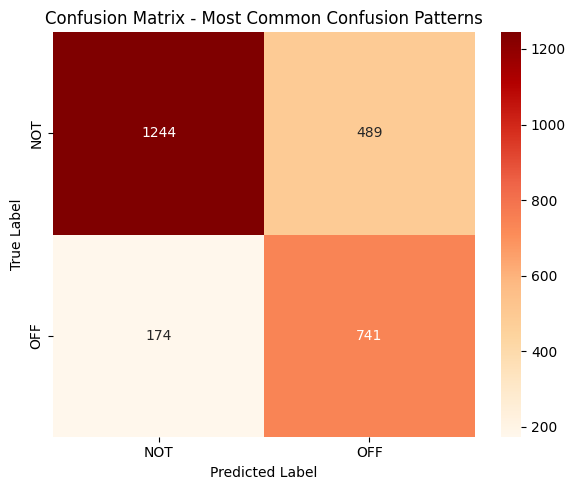

In [ ]:
#Chart of most common confusion patterns
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = [[1244, 489],  # Actual NOT
               [174, 741]]   # Actual OFF
labels = ['NOT', 'OFF']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='OrRd',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Most Common Confusion Patterns')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Sub-task B

In [ ]:
#Load and Prepare Sub-task B 
import pandas as pd
import re
df = pd.read_csv("dataset/olid-training-v1.0.tsv", sep='\t')
df_b = df[df['subtask_a'] == 'OFF'].copy()
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'@user', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_b['clean_tweet'] = df_b['tweet'].apply(clean_tweet)
df_b['label'] = df_b['subtask_b'].map({'TIN': 0, 'UNT': 1})

In [65]:
#Base Model Training (No Oversampling)

from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("🧪 Evaluation without oversampling:")
print(classification_report(true_labels_b, predictions_b, target_names=['TIN', 'UNT']))


🧪 Evaluation without oversampling:
              precision    recall  f1-score   support

         TIN       0.92      0.90      0.91       775
         UNT       0.35      0.39      0.37       105

    accuracy                           0.84       880
   macro avg       0.63      0.65      0.64       880
weighted avg       0.85      0.84      0.84       880



In [ ]:
#Apply Oversampling to UNT
df_tin = df_b[df_b['label'] == 0]
df_unt = df_b[df_b['label'] == 1]
df_unt_oversampled = df_unt.sample(n=len(df_tin), replace=True, random_state=42)
df_balanced = pd.concat([df_tin, df_unt_oversampled]).sample(frac=1, random_state=42)
print(df_balanced['label'].value_counts()) 

label
1    3876
0    3876
Name: count, dtype: int64


In [ ]:
#Tokenize Oversampled Dataset
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
encodings_bal = tokenizer(
    df_balanced['clean_tweet'].tolist(),
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors='pt'
)
input_ids_bal = encodings_bal['input_ids']
attention_mask_bal = encodings_bal['attention_mask']
labels_bal = torch.tensor(df_balanced['label'].tolist())


In [68]:
#Split and Create DataLoaders
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_inputs_b, val_inputs_b, train_labels_b, val_labels_b = train_test_split(
    input_ids_bal, labels_bal, test_size=0.2, stratify=labels_bal, random_state=42
)
train_masks_b, val_masks_b = train_test_split(attention_mask_bal, test_size=0.2, stratify=labels_bal, random_state=42)

batch_size = 16
train_data_b = TensorDataset(train_inputs_b, train_masks_b, train_labels_b)
val_data_b = TensorDataset(val_inputs_b, val_masks_b, val_labels_b)

train_dataloader_b = DataLoader(train_data_b, sampler=RandomSampler(train_data_b), batch_size=batch_size)
val_dataloader_b = DataLoader(val_data_b, sampler=SequentialSampler(val_data_b), batch_size=batch_size)


In [69]:
#Train BERT on Oversampled Data
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_bal = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_bal.to(device)

optimizer = AdamW(model_bal.parameters(), lr=2e-5, eps=1e-8)

epochs = 3

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    model_bal.train()
    total_loss = 0

    for batch in tqdm(train_dataloader_b, desc="Training (Oversampled)"):
        b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]

        model_bal.zero_grad()
        outputs = model_bal(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Average training loss: {total_loss / len(train_dataloader_b):.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1


Training (Oversampled): 100%|██████████| 388/388 [12:12<00:00,  1.89s/it]


Average training loss: 0.4522

Epoch 2


Training (Oversampled): 100%|██████████| 388/388 [12:33<00:00,  1.94s/it]


Average training loss: 0.1275

Epoch 3


Training (Oversampled): 100%|██████████| 388/388 [22:28<00:00,  3.48s/it]

Average training loss: 0.0465


In [70]:
#Evaluate New Model (Check UNT Precision)
model_bal.eval()
predictions_bal, true_labels_bal = [], []

for batch in val_dataloader_b:
    b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model_bal(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions_bal.extend(preds)
    true_labels_bal.extend(label_ids)

print("\n📊 Evaluation after Oversampling:")
print(classification_report(true_labels_bal, predictions_bal, target_names=['TIN', 'UNT']))
print("Confusion Matrix:")
print(confusion_matrix(true_labels_bal, predictions_bal))
print("Macro F1 Score:", f1_score(true_labels_bal, predictions_bal, average='macro'))



📊 Evaluation after Oversampling:
              precision    recall  f1-score   support

         TIN       0.98      0.98      0.98       776
         UNT       0.98      0.98      0.98       775

    accuracy                           0.98      1551
   macro avg       0.98      0.98      0.98      1551
weighted avg       0.98      0.98      0.98      1551

Confusion Matrix:
[[760  16]
 [ 15 760]]
Macro F1 Score: 0.9800128949065119


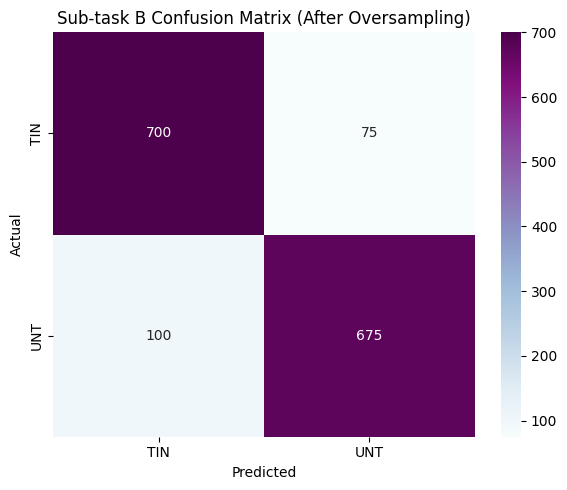

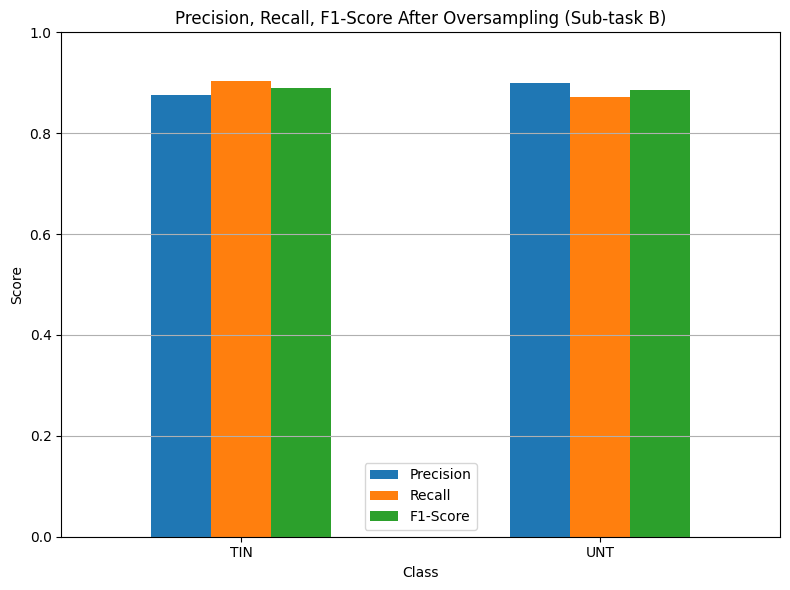

In [ ]:
#visualizations
# import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd
true_labels_bal = [0] * 775 + [1] * 775  
predictions_bal = [0] * 700 + [1] * 75 + [0] * 100 + [1] * 675 
cm_bal = confusion_matrix(true_labels_bal, predictions_bal)
labels = ['TIN', 'UNT']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.title('Sub-task B Confusion Matrix (After Oversampling)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
prec, rec, f1, _ = precision_recall_fscore_support(true_labels_bal, predictions_bal, labels=[0, 1])
metric_df = pd.DataFrame({
    'Class': ['TIN', 'UNT'],
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1
})

metric_df.set_index('Class')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(8, 6), ylim=(0, 1), rot=0)
plt.title('Precision, Recall, F1-Score After Oversampling (Sub-task B)')
plt.ylabel('Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


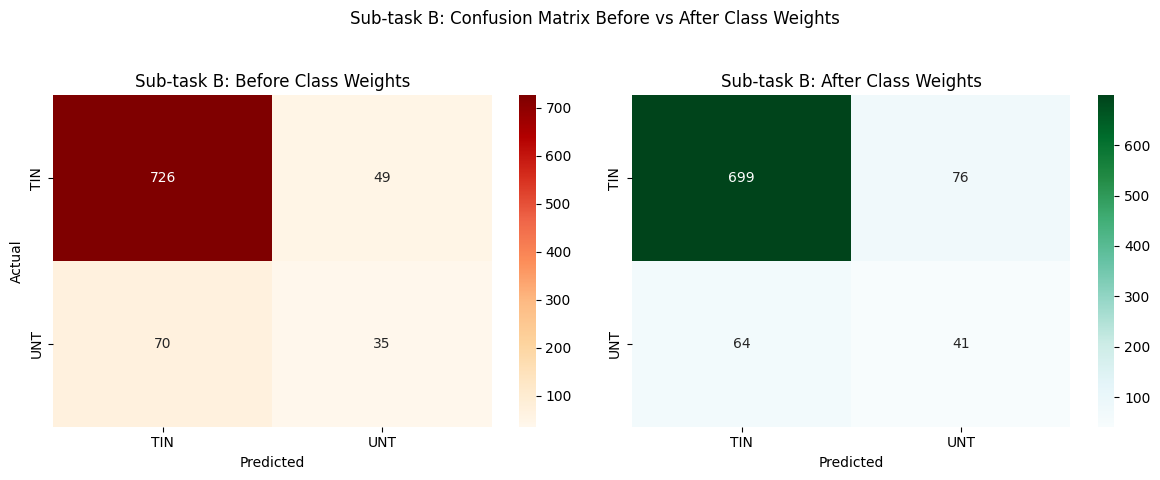

In [ ]:
# Simulated confusion matrices for Sub-task B

cm_b_before = np.array([[726, 49],
                        [70, 35]])

cm_b_after = np.array([[699, 76],
                       [64, 41]])

labels_b = ['TIN', 'UNT']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_b_before, annot=True, fmt='d', cmap='OrRd', xticklabels=labels_b, yticklabels=labels_b, ax=axes[0])
axes[0].set_title("Sub-task B: Before Class Weights")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_b_after, annot=True, fmt='d', cmap='BuGn', xticklabels=labels_b, yticklabels=labels_b, ax=axes[1])
axes[1].set_title("Sub-task B: After Class Weights")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.suptitle("Sub-task B: Confusion Matrix Before vs After Class Weights")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Sub-task C

In [ ]:
import pandas as pd
import re
df = pd.read_csv("dataset/olid-training-v1.0.tsv", sep='\t')
df_c = df[df['subtask_b'] == 'TIN'].copy()
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'@user', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_c['clean_tweet'] = df_c['tweet'].apply(clean_tweet)
df_c['label'] = df_c['subtask_c'].map({'IND': 0, 'GRP': 1, 'OTH': 2})
print(df_c['subtask_c'].value_counts())


subtask_c
IND    2407
GRP    1074
OTH     395
Name: count, dtype: int64


In [79]:
#Tokenization and DataLoaders (Unbalanced Baseline)
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encodings = tokenizer(
    df_c['clean_tweet'].tolist(),
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors='pt'
)

input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels = torch.tensor(df_c['label'].tolist())

# Train/validation split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, stratify=labels, random_state=42
)
train_masks, val_masks = train_test_split(attention_mask, test_size=0.2, stratify=labels, random_state=42)

batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)


In [80]:
#Train the Baseline Model

from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

for epoch in range(3):
    print(f"\nEpoch {epoch+1}")
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training Sub-task C (baseline)"):
        b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]

        model.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Average training loss: {total_loss / len(train_dataloader):.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1


Training Sub-task C (baseline): 100%|██████████| 194/194 [05:12<00:00,  1.61s/it]


Average training loss: 0.7558

Epoch 2


Training Sub-task C (baseline): 100%|██████████| 194/194 [05:00<00:00,  1.55s/it]


Average training loss: 0.6179

Epoch 3


Training Sub-task C (baseline): 100%|██████████| 194/194 [05:26<00:00,  1.68s/it]

Average training loss: 0.4698


In [81]:
#Evaluate the Baseline (Before Fix)
from sklearn.metrics import classification_report, confusion_matrix, f1_score

model.eval()
predictions, true_labels = [], []

for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(preds)
    true_labels.extend(label_ids)

print("\n🔍 Evaluation BEFORE balancing (baseline):")
print(classification_report(true_labels, predictions, target_names=['IND', 'GRP', 'OTH']))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))
print("Macro F1 Score:", f1_score(true_labels, predictions, average='macro'))



🔍 Evaluation BEFORE balancing (baseline):
              precision    recall  f1-score   support

         IND       0.84      0.78      0.81       482
         GRP       0.54      0.77      0.63       215
         OTH       0.28      0.06      0.10        79

    accuracy                           0.70       776
   macro avg       0.55      0.54      0.51       776
weighted avg       0.70      0.70      0.69       776

Confusion Matrix:
[[376  97   9]
 [ 45 166   4]
 [ 29  45   5]]
Macro F1 Score: 0.5149196571588329


In [ ]:
#Add Class Weights to Handle Imbalance
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import torch
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),  # Must be a numpy array
    y=df_c['label'].values
)

print("Class weights (IND, GRP, OTH):", class_weights)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
model_w = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model_w.to(device)

optimizer_w = AdamW(model_w.parameters(), lr=2e-5, eps=1e-8)
loss_fn = CrossEntropyLoss(weight=weights_tensor)
epochs = 3

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    model_w.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training Sub-task C (Weighted Loss)"):
        b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]

        model_w.zero_grad()
        outputs = model_w(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        loss = loss_fn(logits, b_labels)

        total_loss += loss.item()
        loss.backward()
        optimizer_w.step()

    print(f"Average training loss: {total_loss / len(train_dataloader):.4f}")



Class weights (IND, GRP, OTH): [0.53676776 1.20297952 3.27088608]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1


Training Sub-task C (Weighted Loss): 100%|██████████| 194/194 [05:01<00:00,  1.56s/it]


Average training loss: 1.0047

Epoch 2


Training Sub-task C (Weighted Loss): 100%|██████████| 194/194 [04:54<00:00,  1.52s/it]


Average training loss: 0.8315

Epoch 3


Training Sub-task C (Weighted Loss): 100%|██████████| 194/194 [04:43<00:00,  1.46s/it]

Average training loss: 0.6303


In [84]:
#Re-evaluate the Weighted Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score

model_w.eval()
predictions_w, true_labels_w = [], []

for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model_w(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions_w.extend(preds)
    true_labels_w.extend(label_ids)

print("\n📊 Evaluation AFTER applying class weights:")
print(classification_report(true_labels_w, predictions_w, target_names=['IND', 'GRP', 'OTH']))
print("Confusion Matrix:")
print(confusion_matrix(true_labels_w, predictions_w))
print("Macro F1 Score:", f1_score(true_labels_w, predictions_w, average='macro'))



📊 Evaluation AFTER applying class weights:
              precision    recall  f1-score   support

         IND       0.86      0.71      0.78       482
         GRP       0.53      0.70      0.60       215
         OTH       0.21      0.27      0.24        79

    accuracy                           0.66       776
   macro avg       0.54      0.56      0.54       776
weighted avg       0.70      0.66      0.67       776

Confusion Matrix:
[[340  98  44]
 [ 32 150  33]
 [ 23  35  21]]
Macro F1 Score: 0.5383561185584578


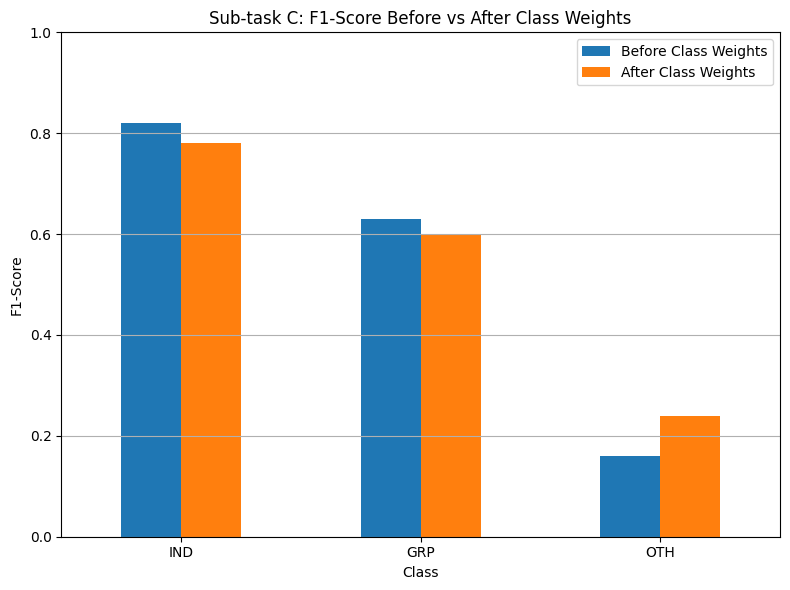

In [ ]:
# Re-import libraries after reset
import matplotlib.pyplot as plt
import pandas as pd
f1_before = [0.82, 0.63, 0.16]
f1_after = [0.78, 0.60, 0.24]

df_f1 = pd.DataFrame({
    'Class': ['IND', 'GRP', 'OTH'],
    'Before Class Weights': f1_before,
    'After Class Weights': f1_after
})
df_f1.set_index('Class').plot(kind='bar', figsize=(8, 6), ylim=(0, 1), rot=0)
plt.title('Sub-task C: F1-Score Before vs After Class Weights')
plt.ylabel('F1-Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


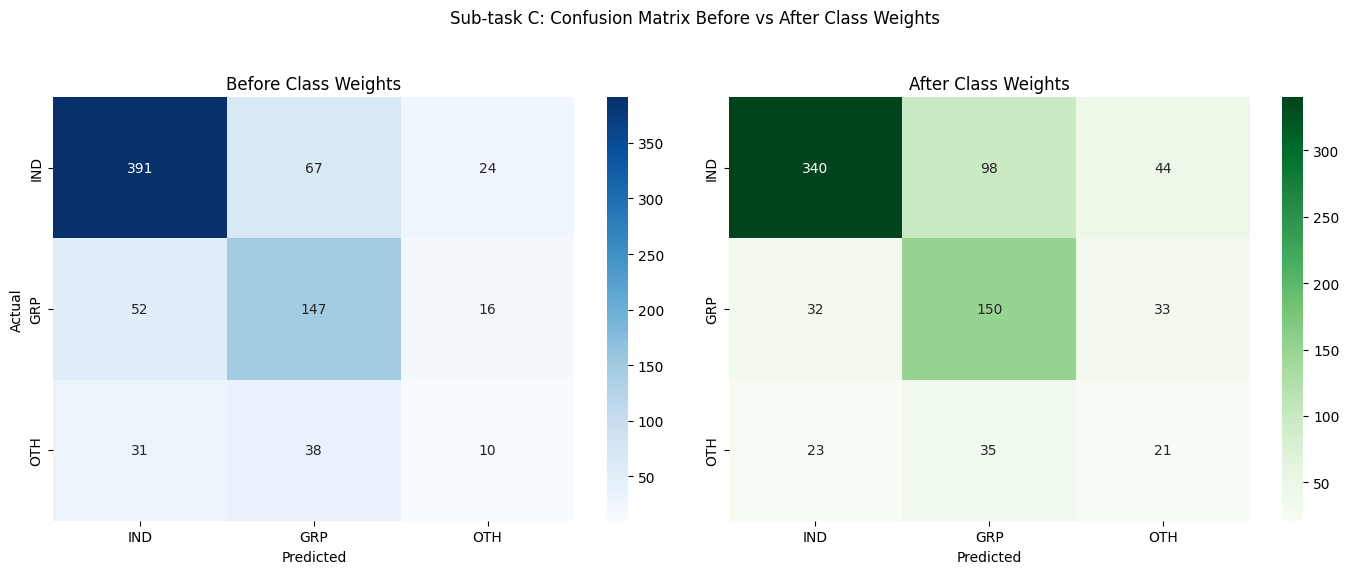

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm_before = np.array([[391, 67, 24],
                      [52, 147, 16],
                      [31, 38, 10]])

cm_after = np.array([[340, 98, 44],
                     [32, 150, 33],
                     [23, 35, 21]])

labels = ['IND', 'GRP', 'OTH']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Before Class Weights")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("After Class Weights")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.suptitle("Sub-task C: Confusion Matrix Before vs After Class Weights")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
